In [1]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy import stats
from scipy.stats import normaltest
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
from scipy.stats import binom
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from matplotlib.colors import ListedColormap
from BorutaShap import BorutaShap
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing,datasets, linear_model, tree, ensemble
from sklearn.preprocessing import StandardScaler, MinMaxScaler,Normalizer,decomposition
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV ,cross_val_score # Evaluate a score by cross-validation
# metrics used for evaluation
from sklearn.metrics import confusion_matrix,RocCurveDisplay, auc, recall_score,precision_score, precision_recall_curve, PrecisionRecallDisplay,f1_score, matthews_corrcoef, roc_auc_score,plot_roc_curve, make_scorer, classification_report,accuracy_score,confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix,log_loss, cohen_kappa_score
# KNN imputation
from sklearn.impute import KNNImputer,IterativeImputer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn_evaluation.plot import grid_search
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Read files 

In [2]:
def read_features():
    path ='secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
x = read_features()
y = read_target().iloc[:,0]

# Data Preparation

## Merge data

In [3]:
#df= pd.concat([df_features,df_target],axis=1)

## Split Training and test data 

In [4]:
x = read_features()
y = read_target().iloc[:,0]

result = []
i = 0

#step 1:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1, stratify=y)

## Removing Duplicated Columns

In [5]:
result = []
i = 0

In [6]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

x = remove_duplicated_columns(x)
x.shape

(1567, 486)

In [7]:
x_train = remove_duplicated_columns(x_train)

## Removing Missing Values 

In [8]:
#Function to show null values with percentage
def null_values(df):
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [9]:
#Ordering columns according to percentage of missing values that they include
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature_158,1144,91.300878
feature_294,1144,91.300878
feature_293,1144,91.300878
feature_159,1144,91.300878
feature_493,1072,85.554669
...,...,...
feature_367,1,0.079808
feature_366,1,0.079808
feature_145,1,0.079808
feature_146,1,0.079808


In [10]:
#Dataframe includes only the columns which consist of 80% of missing values
miss_threshold=80
x_train_na= x_train_na[x_train_na["Percentage (%)"] > miss_threshold]
x_train_na

,Missing_Records,Percentage (%)
feature_158,1144,91.300878
feature_294,1144,91.300878
feature_293,1144,91.300878
feature_159,1144,91.300878
feature_493,1072,85.554669
feature_359,1072,85.554669
feature_86,1072,85.554669
feature_221,1072,85.554669


In [11]:
#Dropping columns which inclues 80% of missing values
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 478)

## Removing Constant Voltality

In [12]:
x_train_new_eda= x_train_new.describe().T
x_train_new_eda

,count,mean,std,min,25%,50%,75%,max
feature_1,1248.0,3014.113686,73.877303,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500
feature_2,1247.0,2496.400585,79.188651,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400
feature_3,1243.0,2200.216525,29.939025,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667
feature_4,1243.0,1394.907987,436.632421,0.0000,1083.8858,1283.43680,1593.122000,3715.0417
feature_5,1243.0,4.018582,54.572445,0.6815,1.0160,1.31710,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
feature_586,1252.0,3.084501,3.968128,1.1975,2.3058,2.74655,3.258475,99.3032
feature_587,1252.0,0.021521,0.012421,-0.0060,0.0134,0.02070,0.027600,0.1028
feature_588,1252.0,0.016344,0.008698,0.0042,0.0106,0.01480,0.019800,0.0799
feature_589,1252.0,0.005248,0.002850,0.0012,0.0033,0.00460,0.006300,0.0286


In [13]:
#Columns that have 0 standard deviation
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature_6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature_14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature_50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature_53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_70,1248.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature_98,1249.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_142,1243.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_179,1234.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_191,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Removing columns that have 0 standard deviation
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

## Outlier Treatment

In [15]:
# Copying train data
x_train_3s=x_train_new_2.copy()

In [16]:
#Function that replaces outliers with 3s boundraies
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [17]:
zscore(x_train_3s,x_train_3s.columns,3)

## Imputation

### KNN Imputation

In [18]:
#Scaling before imputation
scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
x_train_scaled

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7,feature_8,feature_9,feature_10,feature_11,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,feature_590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [19]:
# Impute missing values and save it as a temporary dataset
knn = KNNImputer(weights='distance')
imputed_train = pd.DataFrame(knn.fit_transform(x_train_scaled), columns = x_train_scaled.columns)

In [20]:
imputed_train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7,feature_8,feature_9,feature_10,feature_11,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,feature_590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,0.419934,0.229978,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,0.277680,0.172202,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,0.237025,0.337292,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,0.213805,0.129369,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,0.250725,0.155534,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,0.319653,0.106344,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [21]:
#After imputation rescale the data
retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

## Feature Selection

### Boruta Shap with Random Forest

In [22]:
#Boruta Shap function with random forest
def BorutaShapFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)
    modelshap.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
    return  feature_selector.Subset()


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


18 attributes confirmed important: ['feature_435', 'feature_60', 'feature_66', 'feature_34', 'feature_332', 'feature_349', 'feature_283', 'feature_22', 'feature_65', 'feature_461', 'feature_133', 'feature_478', 'feature_342', 'feature_124', 'feature_206', 'feature_442', 'feature_164', 'feature_299']
447 attributes confirmed unimportant: ['feature_216', 'feature_523', 'feature_146', 'feature_556', 'feature_336', 'feature_318', 'feature_540', 'feature_28', 'feature_356', 'feature_30', 'feature_35', 'feature_58', 'feature_45', 'feature_474', 'feature_134', 'feature_245', 'feature_101', 'feature_246', 'feature_304', 'feature_151', 'feature_443', 'feature_347', 'feature_13', 'feature_512', 'feature_589', 'feature_447', 'feature_249', 'feature_457', 'feature_163', 'feature_268', 'feature_81', 'feature_580', 'feature_225', 'feature_424', 'feature_90', 'feature_11', 'feature_125', 'feature_565', 'feature_391', 'feature_394', 'feature_296', 'feature_377', 'feature_99', 'feature_501', 'feature_2

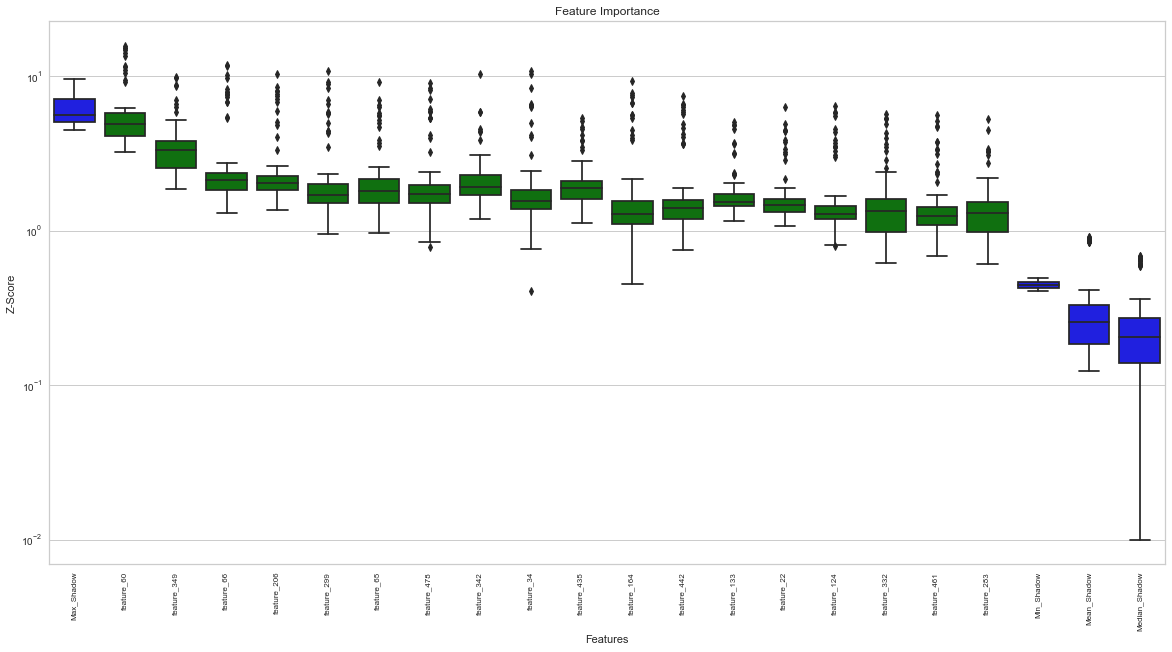

In [23]:
X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train)

<AxesSubplot:>

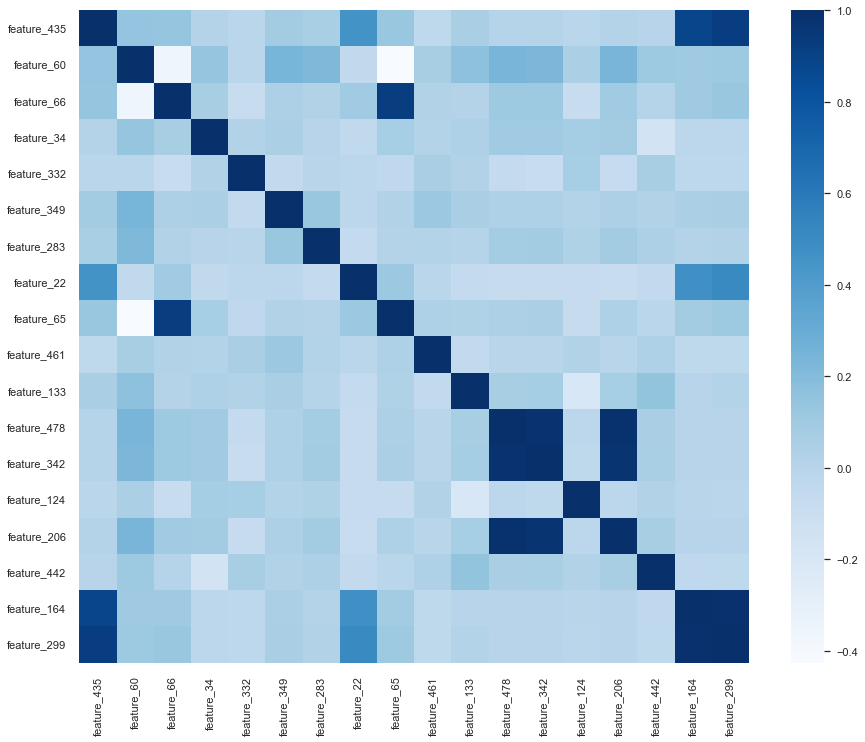

In [24]:
# Correlation map for selected features
sns.set(rc = {'figure.figsize':(15,12)})
X_trainshap.corr()
sns.heatmap(X_trainshap.corr(),cmap="Blues")

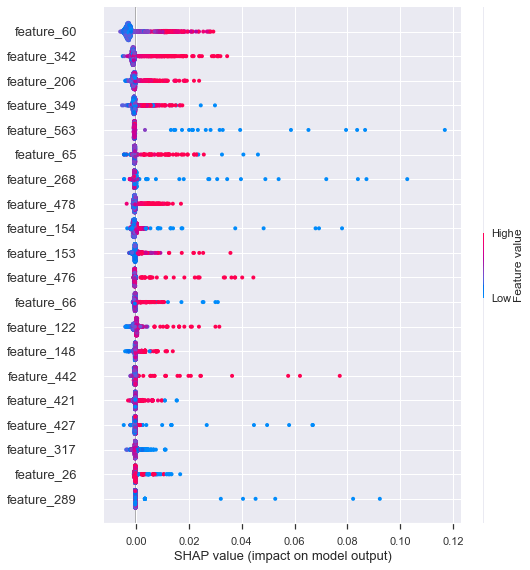

In [25]:
import shap # package used to calculate Shap values
modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)
modelshap.fit(retransformed_train,y_train)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(modelshap)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(retransformed_train)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], retransformed_train)

# Preparation of Test Data

In [26]:
#Filtering dublicated columns fom test set
x_test_1 = x_test.loc[:,x_train.columns]

In [27]:
#Filtering missing columns fom test set
x_test_2= x_test_1.loc[:,x_train_new.columns]

In [28]:
#Filtering constant volatiliy columns fom test set
x_test= x_test_2.loc[:,x_train_new_2.columns]

In [29]:
#Outlier treatment of test set
zscore(x_test,x_test.columns,3)

In [30]:
#Imputation of Test Data
imputed_test = pd.DataFrame(knn.transform(x_test), columns = x_test.columns)

In [31]:
imputed_test.isna().any().any()

False

In [32]:
#Filtering the features from test set based on train set 
X_test = imputed_test.filter(X_trainshap.columns)

## Balancing of Train data

In [33]:
#Function for balancing of train data 
def Sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100,sampling_strategy=1.0)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1,sampling_strategy=1.0)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100,sampling_strategy=1.0)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100,sampling_strategy=1.0)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [34]:
X_resampled, y_resampled = Sampling(X_trainshap, y_train,'SMOTEENN')

Counter({1: 1018, -1: 755})


In [35]:
y_test.value_counts(normalize=True)*100

-1    93.312102
 1     6.687898
Name: status, dtype: float64

# Building Model

## Random Forest/ Grid search and Cross Validation (5-fold)

In [ ]:
#set seed for consistent results
np.random.seed(42)

In [ ]:
# Create the random grid
rf_params = {'n_estimators': [250],
               'criterion' : ['entropy'],
               'max_features': ['sqrt'],
               'max_depth': [7],
               'min_samples_split': [50],
               'min_samples_leaf': [1],
               'class_weight' : ['balanced_subsample'],
               'max_samples' : [400]
              }

In [ ]:
# Create a base model to tune
rf = RandomForestClassifier(random_state=150)
# Grid Search
rf_random = GridSearchCV(estimator = rf, param_grid = rf_params, scoring='roc_auc', cv = 5, verbose=1)
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=150),
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['entropy'], 'max_depth': [7],
                         'max_features': ['sqrt'], 'max_samples': [400],
                         'min_samples_leaf': [1], 'min_samples_split': [50],
                         'n_estimators': [250]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Printing the best Parameters and best estimator
print('\n Best estimator:')
print(rf_random.best_estimator_)

print('\n Best hyperparameters:')
print(rf_random.best_params_)


 Best estimator:
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='sqrt', max_samples=400,
                       min_samples_split=50, n_estimators=250,
                       random_state=150)

 Best hyperparameters:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'max_samples': 400, 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 250}


In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(rf_random.best_estimator_, X_resampled, y_resampled, cv=cv, scoring = 'recall')
print(scores.mean())
# fit
rf=rf_random.best_estimator_.fit(X_resampled, y_resampled)    
# predict
y_pred_test = rf_random.best_estimator_.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

0.8329952670723462
Test Accuracy :  0.7770700636942676


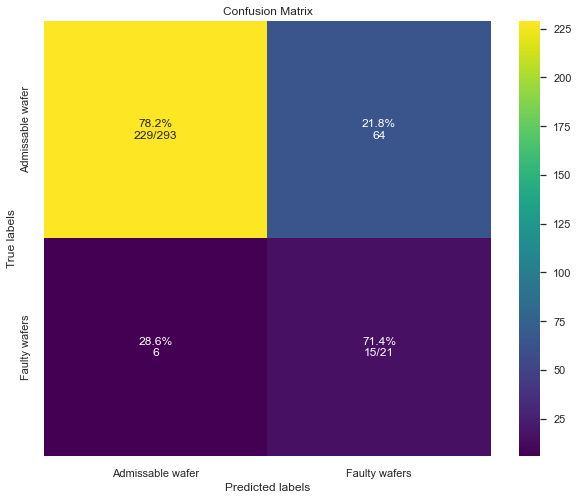

              precision    recall  f1-score   support

          -1       0.97      0.78      0.87       293
           1       0.19      0.71      0.30        21

    accuracy                           0.78       314
   macro avg       0.58      0.75      0.58       314
weighted avg       0.92      0.78      0.83       314



In [ ]:
#Confusion matrix and classification report 
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='viridis')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Admissable wafer','Faulty wafers']); ax.yaxis.set_ticklabels(['Admissable wafer', 'Faulty wafers',]);
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred_test, rf_random.classes_, ymap=None, figsize=(10,8))
print(classification_report(y_test, y_pred_test)) 

In [ ]:
#function for saving results for this model
def run_model(X_train, y_train, X_test, y_test):

    model=rf_random.best_estimator_.fit(X_resampled, y_resampled)  

    #For TEST SPLIT
    y_pred= model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    GINI = (2 * auc) - 1
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]

    return cf_matrix, accuracy, f1, precision, recall, specificity, type_1_error_FP, type_2_error_FN, auc,GINI, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, specificity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train


In [ ]:
run_model(X_resampled, y_resampled, X_test, y_test)

(array([[229,  64],
        [  6,  15]], dtype=int64),
 0.7770700636942676,
 0.30000000000000004,
 0.189873417721519,
 0.7142857142857143,
 0.7142857142857143,
 64,
 6,
 0.7479278400780107,
 0.49585568015602144,
 7.699890197067773,
 0.21729221565415568,
 array([[667,  88],
        [139, 879]], dtype=int64),
 0.8719684151156233,
 0.8856423173803526,
 0.9089968976215098,
 0.8634577603143418,
 0.8634577603143418,
 88,
 139,
 0.8734507344618065)

In [ ]:
#Creating csv file for grid search results
df=pd.DataFrame(rf_random.cv_results_)
df.to_csv('cv_results.csv')

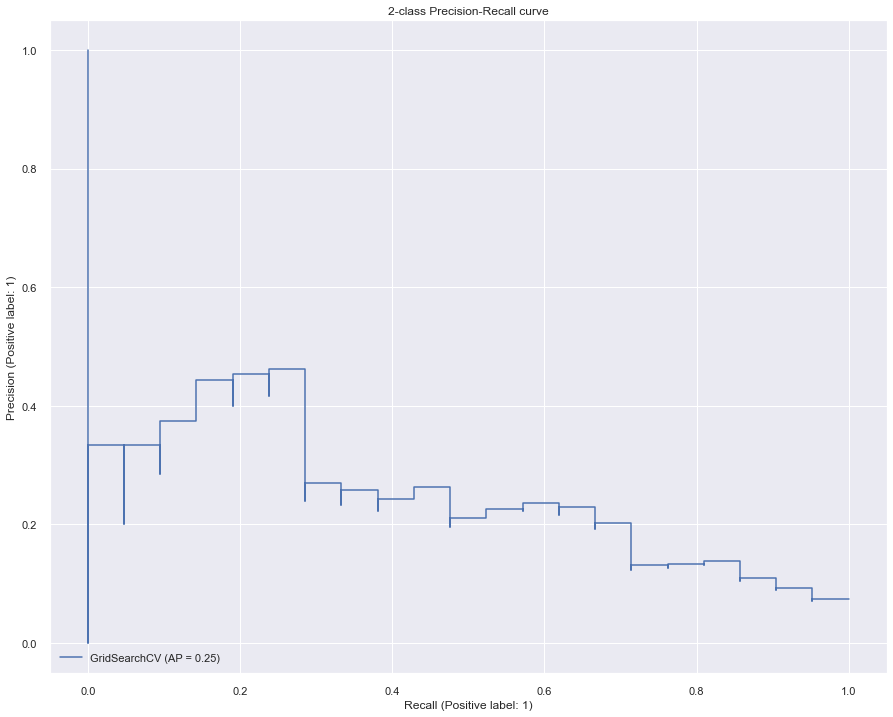

In [ ]:
#Precision Recall curve
display = PrecisionRecallDisplay.from_estimator(
    rf_random, X_test, y_test
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

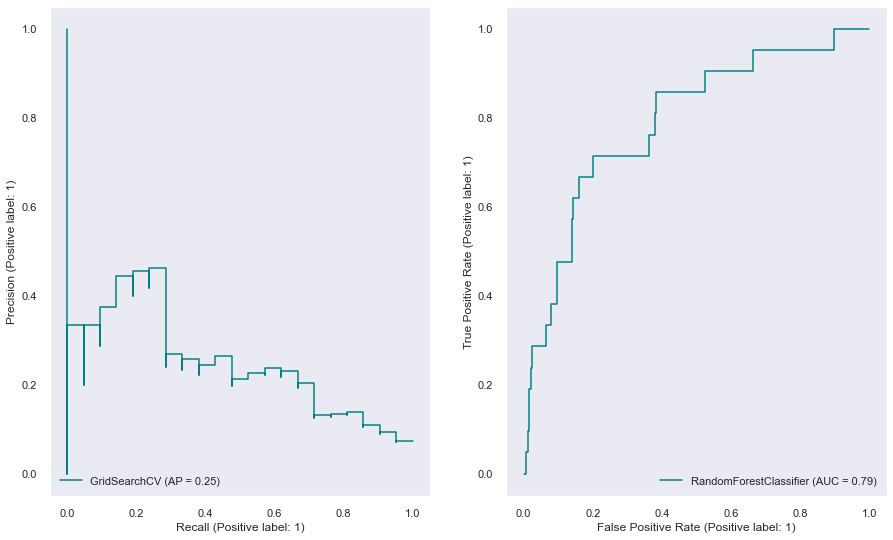

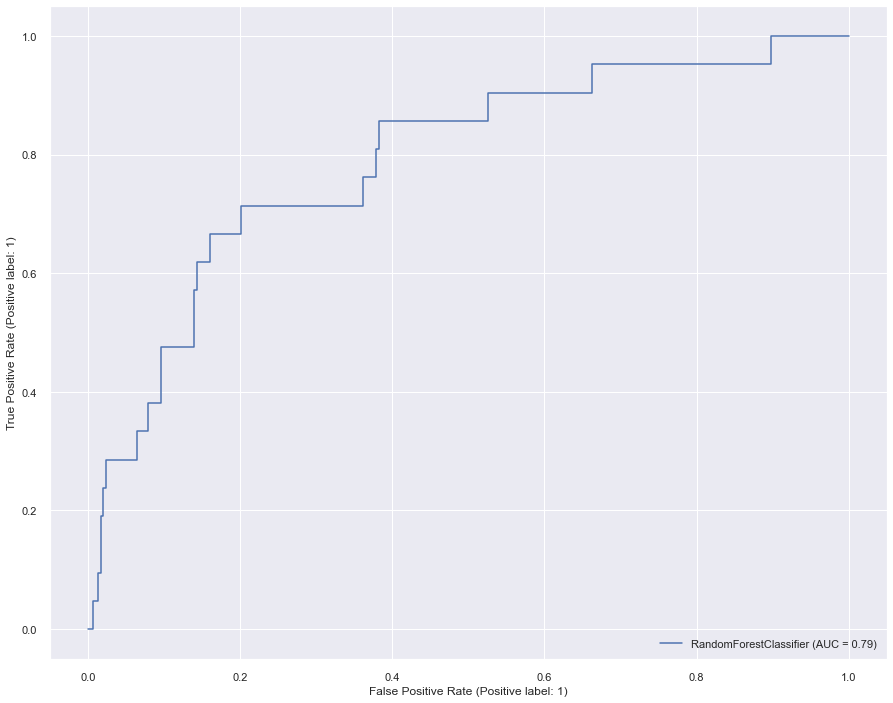

In [ ]:
#Roc and precision-recall curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
ax1.grid(False)
ax2.grid(False)
display.plot(ax=ax1, color='teal')
metrics.RocCurveDisplay.from_estimator(rf_random.best_estimator_, X_test, y_test).plot(ax=ax2,color='teal')
plt.show()

## Gradient Boosting/ Grid search and Cross Validation (5-fold)

In [37]:
#set seed for consistent results
#even using seed gradient boosting gives different result evertime we train the data even with the same results
np.random.seed(100)

In [71]:
param_grad = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[3,5,8],
    "max_features":["log2"],
    "criterion": ["friedman_mse"],
    "subsample":[1],
    "n_estimators":[500,750,800,1000]
    }

In [80]:
grid= GridSearchCV(GradientBoostingClassifier(),param_grid= param_grad, cv=5, verbose=1, n_jobs=-1, scoring='recall')
 
# fitting the model for grid search
grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['deviance'], 'max_depth': [3, 5, 8],
                         'max_features': ['log2'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [500, 750, 800, 1000],
                         'subsample': [1]},
             scoring='recall', verbose=1)

In [81]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'subsample': 1}
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features='log2',
                           n_estimators=1000, subsample=1)


In [82]:
# fit
grad=grid.best_estimator_.fit(X_resampled, y_resampled)    
# predict
y_pred_test = grid.best_estimator_.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

Test Accuracy :  0.8949044585987261


In [110]:
plt.rcParams['font.size'] =13

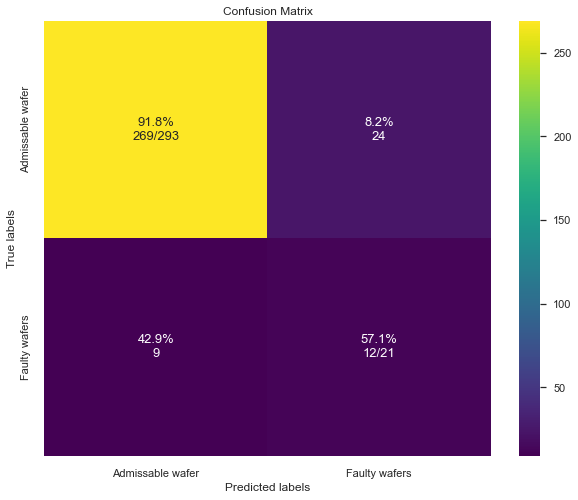

              precision    recall  f1-score   support

          -1       0.97      0.92      0.94       293
           1       0.33      0.57      0.42        21

    accuracy                           0.89       314
   macro avg       0.65      0.74      0.68       314
weighted avg       0.93      0.89      0.91       314



In [111]:
#Confusion matrix and claasification report 
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='viridis')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Admissable wafer','Faulty wafers']); ax.yaxis.set_ticklabels(['Admissable wafer', 'Faulty wafers',]);
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred_test, grid.classes_, ymap=None, figsize=(10,8))
print(classification_report(y_test, y_pred_test)) 

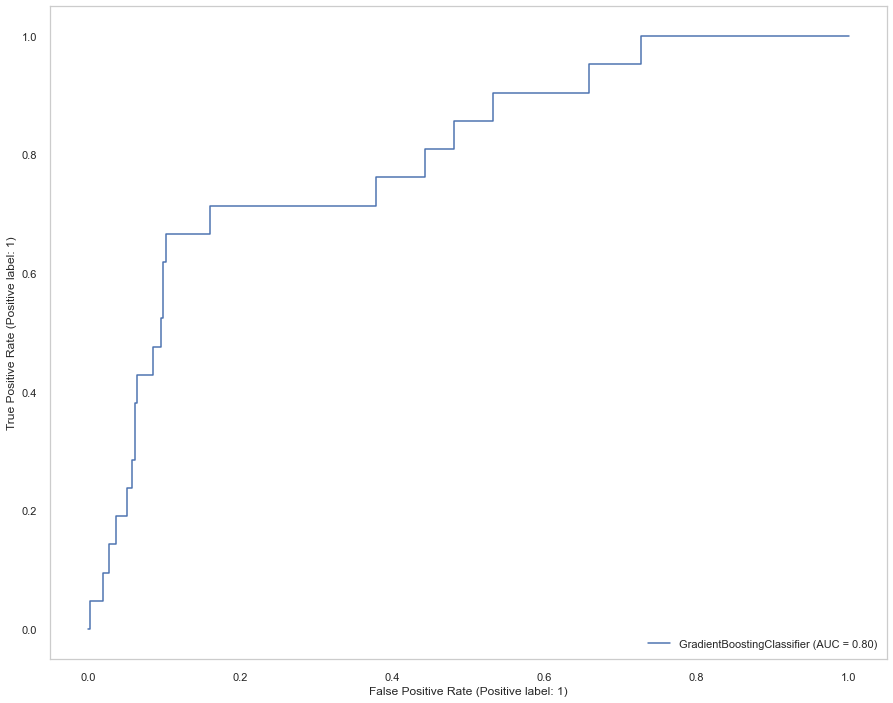

In [112]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(grid.best_estimator_, X_test, y_test)
plt.show()

In [ ]:
# Csv file for grid search results
df=pd.DataFrame(grid.cv_results_)
df.to_csv('cv_resultsgrid8.csv')

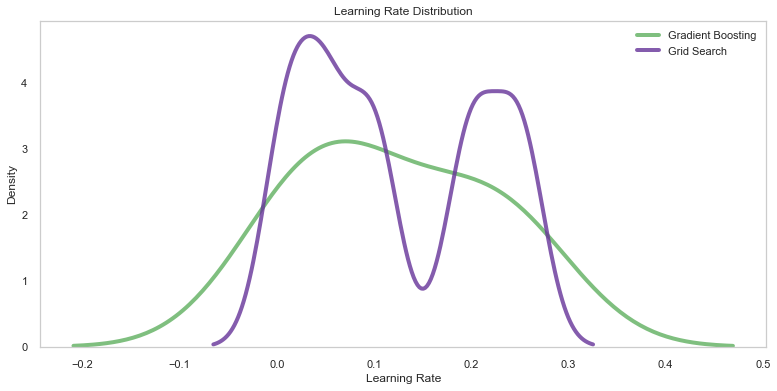

In [ ]:
#Kernel density estimate plot of learning distributions
plt.figure(figsize = (13, 6))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(param_grad['learning_rate'], label = 'Gradient Boosting', linewidth = 4, color= 'green', alpha= 0.5)
sns.kdeplot(df['param_learning_rate'], label = 'Grid Search', linewidth = 4,color= 'rebeccapurple', alpha= 0.8)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

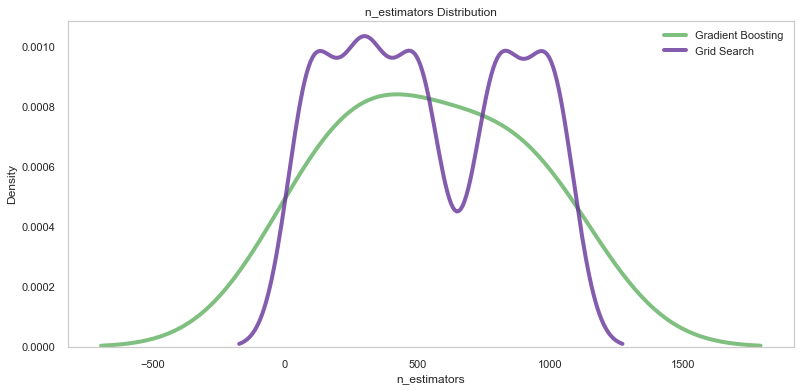

In [ ]:
#Kernel density estimate plot of n_estimators
plt.figure(figsize = (13, 6))
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid", {'axes.grid' : False}) 
sns.kdeplot(param_grad['n_estimators'], label = 'Gradient Boosting', linewidth = 4, color= 'green', alpha= 0.5)
sns.kdeplot(df['param_n_estimators'], label = 'Grid Search', linewidth = 4,color= 'rebeccapurple', alpha= 0.8)
plt.legend()
plt.xlabel('n_estimators'); plt.ylabel('Density'); plt.title('n_estimators Distribution');

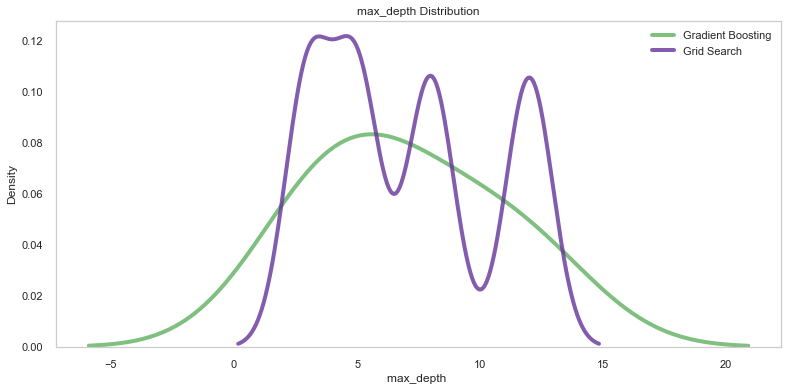

In [ ]:
plt.figure(figsize = (13, 6))
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid", {'axes.grid' : False})
''
# Density plots of the learning rate distributions 
sns.kdeplot(param_grad['max_depth'], label = 'Gradient Boosting', linewidth = 4, color= 'green', alpha= 0.5)
sns.kdeplot(df['param_max_depth'], label = 'Grid Search', linewidth = 4,color= 'rebeccapurple', alpha= 0.8)
plt.legend()
plt.xlabel('max_depth '); plt.ylabel('Density'); plt.title('max_depth Distribution');

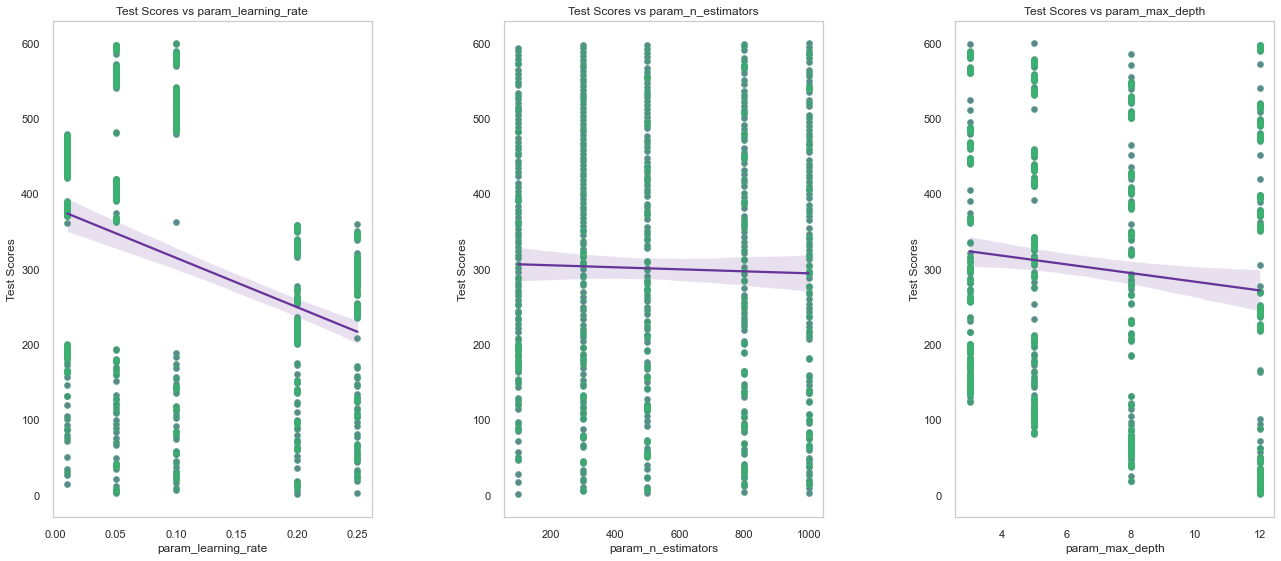

In [ ]:
# Hyperparameters versus test scores
fig, axs = plt.subplots(1, 3, figsize = (20, 10))
plt.rcParams['font.size'] = 10
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['param_learning_rate', 'param_n_estimators', 'param_max_depth']):
        df[hyper] = df[hyper].astype(float)
        # Scatterplot
        sns.regplot(hyper, 'rank_test_score', data = df, ax = axs[i], color = 'rebeccapurple')
        axs[i].scatter(df[hyper], df['rank_test_score'], c = 'mediumseagreen',alpha= 0.5)
        axs[i].set(xlabel = '{}'.format(hyper), ylabel = 'Test Scores', title = 'Test Scores vs {}'.format(hyper));

plt.tight_layout()


## XG Boosting with Grid Search and Cross Validation(5 fold) 

In [ ]:
import xgboost as xgb

In [ ]:
# defining parameter range
param_grad = {
    "learning_rate":[0.01,0.1,0.25],
    'max_depth':[3,5,7],
    "max_features":[2,4],
    "n_estimators":[500,700],
    'eta' : [0.2,0.5],
    'subsample' : [1]
    }

xg= GridSearchCV(XGBClassifier(),param_grid= param_grad, cv=5, verbose=1, n_jobs=-1, scoring=['recall','roc_auc'], refit='recall')
 
# fitting the model for grid search
xg.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[10:35:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:35:41] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

In [ ]:

# print best parameter after tuning
print(xg.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(xg.best_estimator_)

{'eta': 0.2, 'learning_rate': 0.25, 'max_depth': 5, 'max_features': 2, 'n_estimators': 500, 'subsample': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=5, max_features=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(xg.best_estimator_, X_resampled, y_resampled, cv=cv, scoring = 'roc_auc')
print(scores.mean())
# fit
xgb=xg.best_estimator_.fit(X_resampled, y_resampled)    
# predict
y_pred_test = xg.best_estimator_.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

[10:35:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:35:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

## Voting Classifier 

In [ ]:
#Using 3 different tree based model for ensembling method
vc=VotingClassifier([('clf1',rf),('clf2',grad),('clf3',xgb)])
cross_val_score(vc,X_resampled,y_resampled).mean()

[19:37:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:37:56] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:37:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

0.9661669451738681

In [ ]:
#Hyperparameters 
param={'voting' :['hard','soft'],
        'weights' :  [(1,1,1),(2,1,1),(1,2,1),(1,1,2)]}

In [ ]:
#find best set of parameters
grid_voting= GridSearchCV(vc,param,scoring='recall')
voting=grid_voting.fit(X_resampled,y_resampled)
grid_voting.best_params_

[19:53:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:53:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

{'voting': 'soft', 'weights': (1, 2, 1)}

In [ ]:
#what accuracy is now?
grid_voting.best_score_

0.9921472037090698

In [ ]:
def run_model(X_train, y_train, X_test, y_test):

    model=grid_voting.best_estimator_.fit(X_resampled, y_resampled)  

    #For TEST SPLIT
    y_pred= model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]

    return cf_matrix, accuracy, f1, precision, recall, specificity, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, specificity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train


In [ ]:
run_model(X_resampled, y_resampled, X_test, y_test)

[19:56:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:56:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(array([[268,  25],
        [  8,  13]], dtype=int64),
 0.8949044585987261,
 0.44067796610169496,
 0.34210526315789475,
 0.6190476190476191,
 0.6190476190476191,
 25,
 8,
 0.7668616934828538,
 3.6299350667764574,
 0.3879503839338453,
 array([[ 755,    0],
        [   0, 1018]], dtype=int64),
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0,
 0,
 1.0)

## Adaboost with Grid Search and Cross Validation(5 fold) 

In [ ]:
adb= AdaBoostClassifier(RandomForestClassifier(criterion='entropy'),n_estimators=1000, learning_rate=1)
# Fit the random search model


In [ ]:
parameters = {
    'n_estimators': [900,1000,1200]
}
clf = GridSearchCV(adb,parameters, cv=5,n_jobs=-1,scoring='recall')
ada=clf.fit(X_resampled, y_resampled)

In [ ]:
# Evaluation using Startified K Fold cross validation
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(adb, X_resampled, y_resampled, cv=cv, scoring = 'recall')
print(scores.mean())
# fit
adbb=adb.fit(X_resampled, y_resampled)    
# predict
y_pred_test = adbb.predict(X_test)
# View accuracy score
accuracyFinal = accuracy_score(y_test, y_pred_test)
print('Test Accuracy : ', accuracyFinal)

0.9852747995750025
Test Accuracy :  0.856687898089172


In [ ]:
def run_model(X_train, y_train, X_test, y_test):
    
    model=adbb.fit(X_resampled, y_resampled)  

    #For TEST SPLIT
    y_pred= model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]

    return cf_matrix, accuracy, f1, precision, recall, specificity, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, specificity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train


In [ ]:
run_model(X_resampled, y_resampled, X_test, y_test)

(array([[264,  29],
        [ 12,   9]], dtype=int64),
 0.8694267515923567,
 0.30508474576271183,
 0.23684210526315788,
 0.42857142857142855,
 0.42857142857142855,
 29,
 12,
 0.6647976596782058,
 4.509914078079024,
 0.23957471943295927,
 array([[ 755,    0],
        [   0, 1018]], dtype=int64),
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0,
 0,
 1.0)